# Hand-crafted features for GTZAN

> The goal of this notebook is to create several audio features descriptors for the GTZAN dataset, as proposed for many year as input for machine learning algorithms. We are going to use timbral texture based features and tempo based features for this. The main goal is to produce this features, classify and then compare with our proposed deep learning approach, using CNNs on the raw audio.

In [ ]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from decimal import Decimal

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# Set the seed
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gtzan_dir = '/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/data/genres/'

In [ ]:
# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [ ]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y=y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y=y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y=y
                                                    , sr=sr)[0]
    
    return dict_agg_features

In [ ]:
import os
import librosa
from decimal import Decimal, getcontext

def read_process_songs(src_dir, debug=True):
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x, _ in genres.items():
        print(x)
        folder = os.path.join(src_dir, x)

        for dirs,_, files in os.walk(folder):
            for file in files:
                print(file)
                # Read the audio file
                file_path = os.path.join(folder, file)
                try:
                    signal, sr = librosa.load(file_path)
                except librosa.util.exceptions.ParameterError:
                    print(f"Skipping {file_path} due to unsupported format")
                    continue

                # Debug process
                if debug:
                    print(f"Reading file: {file_path}")

                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)

    return arr_features


In [ ]:


%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

metal
metal.00000.wav


<ipython-input-9-4310a6eb236c>:39: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  dict_agg_features['tempo'] = librosa.beat.tempo(y=y


metal.00003.wav
metal.00002.wav
metal.00001.wav
metal.00018.wav
metal.00020.wav
metal.00005.wav
metal.00011.wav
metal.00007.wav
metal.00016.wav
metal.00012.wav
metal.00008.wav
metal.00019.wav
metal.00017.wav
metal.00015.wav
metal.00010.wav
metal.00021.wav
metal.00006.wav
metal.00004.wav
metal.00022.wav
metal.00009.wav
metal.00014.wav
metal.00013.wav
metal.00033.wav
metal.00037.wav
metal.00032.wav
metal.00031.wav
metal.00024.wav
metal.00040.wav
metal.00035.wav
metal.00039.wav
metal.00026.wav
metal.00027.wav
metal.00023.wav
metal.00036.wav
metal.00025.wav
metal.00028.wav
metal.00030.wav
metal.00038.wav
metal.00034.wav
metal.00029.wav
metal.00053.wav
metal.00043.wav
metal.00041.wav
metal.00055.wav
metal.00051.wav
metal.00049.wav
metal.00048.wav
metal.00045.wav
metal.00047.wav
metal.00044.wav
metal.00056.wav
metal.00052.wav
metal.00054.wav
metal.00046.wav
metal.00050.wav
metal.00057.wav
metal.00042.wav
metal.00073.wav
metal.00068.wav
metal.00067.wav
metal.00074.wav
metal.00065.wav
metal.00

<ipython-input-9-4310a6eb236c>:34: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result['{}_kurtosis'.format(k)] = kurtosis(v)
<ipython-input-9-4310a6eb236c>:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result['{}_skew'.format(k)] = skew(v)


classical.00045.wav
classical.00053.wav
classical.00050.wav
classical.00052.wav
classical.00071.wav
classical.00070.wav
classical.00060.wav
classical.00065.wav
classical.00062.wav
classical.00069.wav
classical.00063.wav
classical.00064.wav
classical.00073.wav
classical.00074.wav
classical.00061.wav
classical.00066.wav
classical.00072.wav
classical.00068.wav
classical.00067.wav
classical.00076.wav
classical.00084.wav
classical.00080.wav
classical.00085.wav
classical.00078.wav
classical.00087.wav
classical.00081.wav
classical.00082.wav
classical.00083.wav
classical.00088.wav
classical.00077.wav
classical.00075.wav
classical.00079.wav
classical.00086.wav
classical.00094.wav
classical.00099.wav
classical.00095.wav
classical.00098.wav
classical.00096.wav
classical.00093.wav
classical.00089.wav
classical.00097.wav
classical.00091.wav
classical.00090.wav
classical.00092.wav
hiphop
hiphop.00004.wav
hiphop.00008.wav
hiphop.00005.wav
hiphop.00002.wav
hiphop.00001.wav
hiphop.00006.wav
hiphop.0000

In [ ]:
df_features = pd.DataFrame(features)

In [ ]:
df_features.shape 

(999, 134)

In [ ]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,5514.393296,1789.366583,3177.044739,550.514460,1.276833,0.851272,9905.273438,4005.175781,6235.752497,1316.817640,...,-0.381935,-0.087352,20.820358,-32.647717,-4.106478,8.183018,0.174438,-0.170466,95.703125,0
1,4141.859853,1554.571724,2700.604011,411.344742,-0.256947,0.124514,7708.886719,3531.445312,5177.960956,678.921135,...,0.151427,-0.124628,16.922087,-34.641380,-13.000867,6.993345,0.378246,0.133764,99.384014,0
2,4137.382271,1196.751465,2147.080162,394.532048,3.597655,1.475513,7751.953125,2842.382812,4376.685986,842.405343,...,-0.231261,-0.070840,11.926426,-40.928547,-14.242151,7.794230,0.155817,-0.128624,112.347147,0
3,5626.545444,1763.465470,2850.278392,450.497575,7.135793,1.871643,10314.404297,4155.908203,5927.176533,852.377153,...,-0.121696,0.048562,19.133057,-32.525146,-10.891161,7.585576,0.191163,0.234933,151.999081,0
4,3475.461978,1280.387933,2258.131020,381.251030,0.206072,0.172976,5921.630859,2368.652344,3852.628109,581.635388,...,-0.175505,0.014120,22.097572,-29.899508,-2.452176,7.726110,0.327553,-0.301343,99.384014,0


In [ ]:
df_features.to_csv('/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/data/gtzan_features.csv', index=False)

In [ ]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

# Visualization
Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

In [ ]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# c) check nan, data imputation
from sklearn.impute import KNNImputer

if np.sum(np.isnan(x_scaled)):
  print('Total of NaN before imputation:', np.sum(np.isnan(x_scaled)))
  imputer = KNNImputer(n_neighbors=2, weights="uniform")
  x_scaled = imputer.fit_transform(x_scaled)
  print('Total of NaN after imputation:', np.sum(np.isnan(x_scaled)))
else:
  print('no NaN')

Total of NaN before imputation: 1998
Total of NaN after imputation: 0


In [ ]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8734


In [ ]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [ ]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.001s...
[t-SNE] Computed neighbors for 999 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 3.340584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.273285
[t-SNE] KL divergence after 1000 iterations: 1.028246


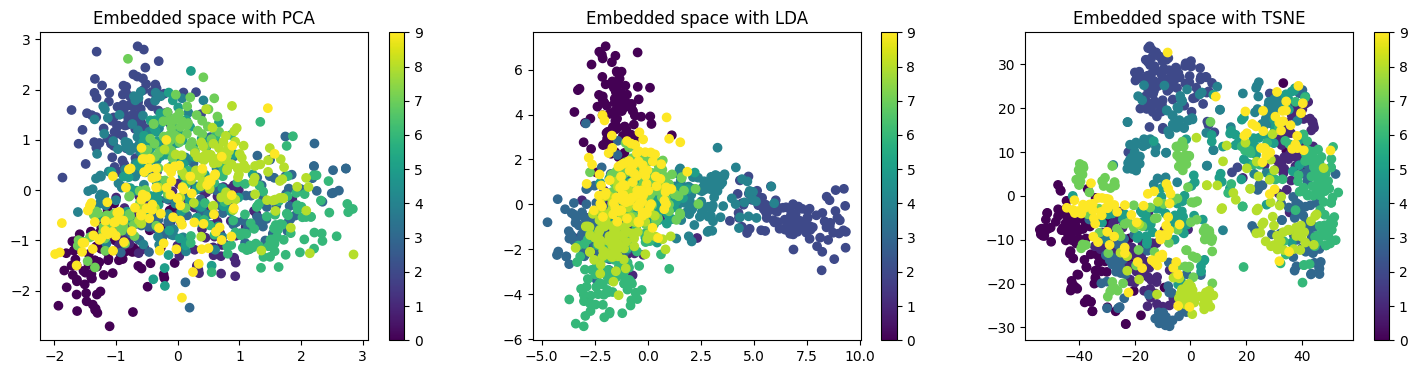

In [ ]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

# Exploraory Data Analysis (EDA)
This is an attemp to understnad how the data and feature are related to each other in a broad sense. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/data/gtzan_features.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-26-5964d7d8bc1e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


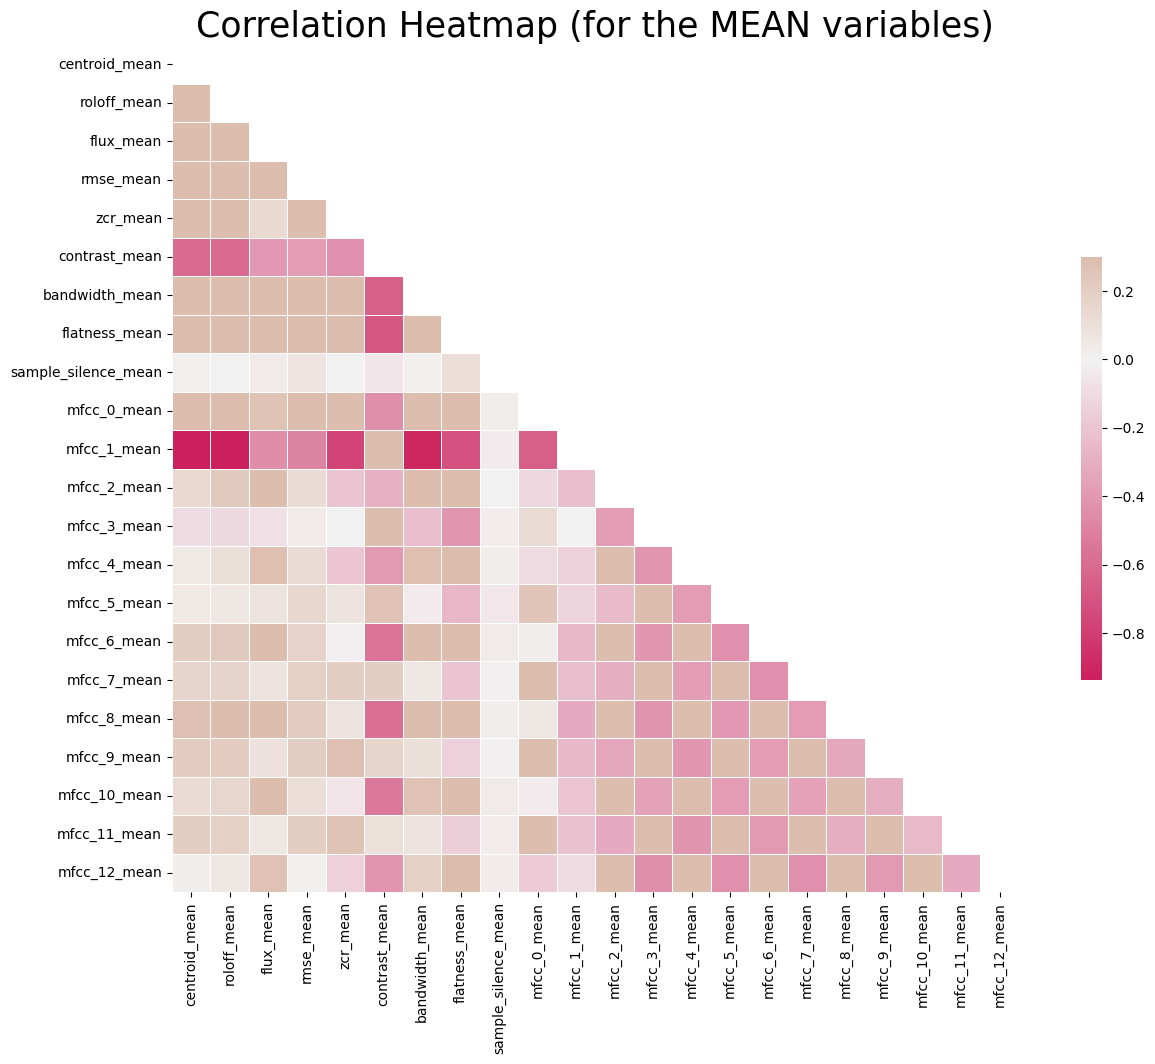

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

In [ ]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
from sklearn.svm import NuSVC
import lightgbm as lgbm
from sklearn.svm import SVC
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=1, cv=5)
grid_svm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=1,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [ ]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7450
best score on test set (accuracy) = 0.7600


In [ ]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

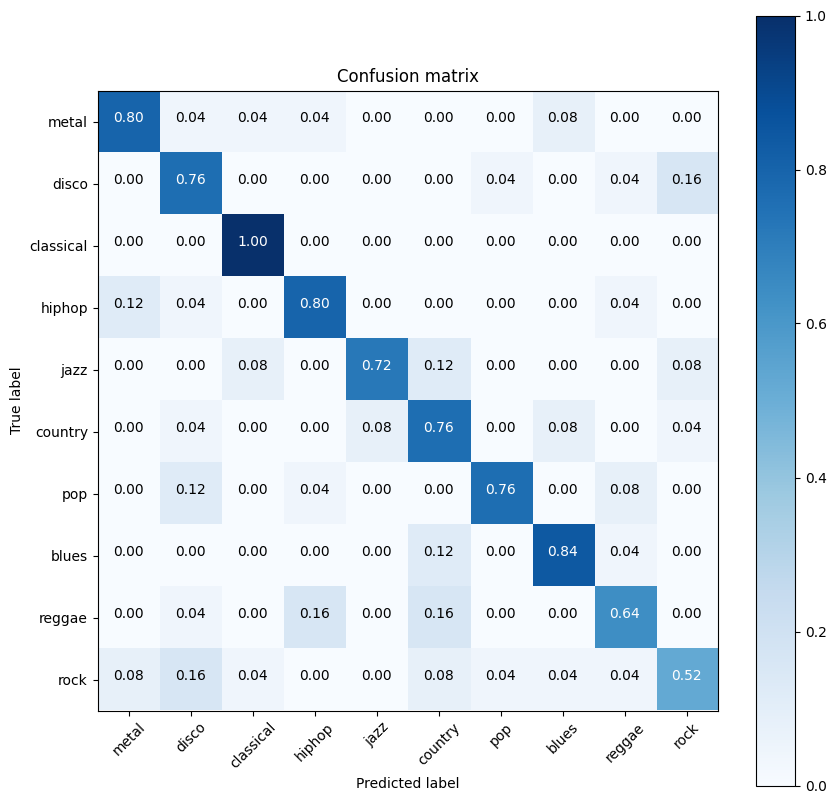

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, preds, average='weighted')

In [ ]:
# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))

Precision: 0.77
Recall: 0.76
F1 Score: 0.76


In [ ]:
import joblib


In [ ]:
joblib.dump(grid_svm, "/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/pipe_svm.joblib")

['/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/pipe_svm.joblib']

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Define the parameter grid for GridSearchCV
params = {
    'cls__learning_rate': [0.05, 0.1, 0.15],
    'cls__max_depth': [3, 5, 7],
    'cls__n_estimators': [50, 100, 200],
    'cls__tree_method': ['gpu_hist']
}

# Define the pipeline
pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', XGBClassifier())
])

# Perform a grid search with cross-validation
grid_xgb = GridSearchCV(pipe_xgb, params, scoring='accuracy', n_jobs=-1, cv=5)
grid_xgb.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rou...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'cls__learning_rate': [0.05, 0.1, 0.15],
                         'cls__max_depth': [3, 5, 7],
                         'cls__n_estimators': [50, 100, 200],
                         'cls__tree_method': ['gpu_hist']},
             scoring='accuracy')

In [ ]:
preds = grid_xgb.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_xgb.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7237
best score on test set (accuracy) = 0.7400


In [ ]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

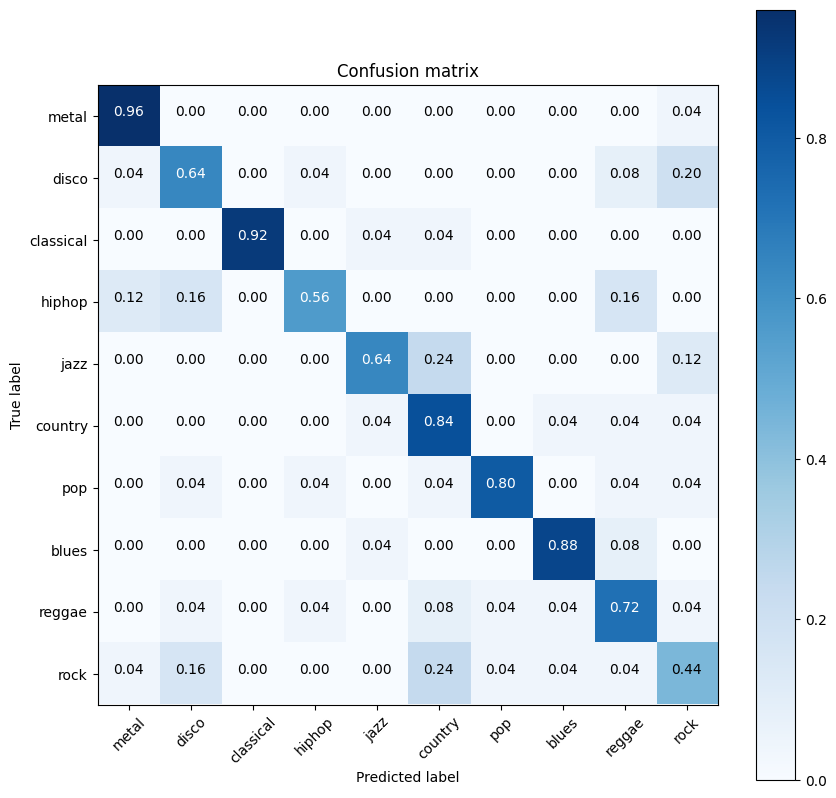

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, preds, average='weighted')

In [ ]:
# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))

Precision: 0.76
Recall: 0.74
F1 Score: 0.74


In [ ]:
joblib.dump(grid_xgb, "/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/model/pipe_xgb.joblib")

['/content/drive/MyDrive/ECE_539_Project/Music_Genre_Classification/model/pipe_xgb.joblib']